In [7]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from tensorflow.python.client import device_lib

ImportError: cannot import name 'keras_tuner' from 'tensorflow' (/Users/bryankikuta/Documents/University/AER850/projects/aer850-project-2/.venv/lib/python3.11/site-packages/tensorflow/__init__.py)

In [3]:
# Enable GPUs if present
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8324927107109362560
xla_global_id: -1
]


# Step 1: Data Processing

In [4]:
image_shape = (500, 500, 3)  # Create tuple for image size

# Establish paths
data_folder = os.path.join("..", "data")
test_path = os.path.join(data_folder, "test")
train_path = os.path.join(data_folder, "train")
valid_path = os.path.join(data_folder, "valid")

# Load the images sets
test_images = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    image_size=(image_shape[0], image_shape[1]),
)
train_images = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels="inferred",
    image_size=(image_shape[0], image_shape[1]),
)
valid_images = keras.utils.image_dataset_from_directory(
    directory=valid_path,
    labels="inferred",
    image_size=(image_shape[0], image_shape[1]),
)

Found 539 files belonging to 3 classes.
Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


# Step 2: Neural Network Architecture Design

In [5]:
def build_model(hp):
    # Initialize the model
    model = models.Sequential(
        [
            layers.Input(shape=image_shape),
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomBrightness(0.2),
            layers.RandomContrast(0.2),
            layers.RandomCrop(400, 400),
            layers.RandomTranslation(0.2, 0.2),
            layers.RandomZoom(0.2),
        ]
    )

    # Tune the number of Conv2D layers (e.g., between 2 and 5 layers)
    for i in range(hp.Int("num_conv_layers", min_value=2, max_value=5)):
        model.add(
            layers.Conv2D(
                filters=hp.Int(
                    f"conv_{i+1}_filters", min_value=32, max_value=128, step=32
                ),
                kernel_size=hp.Choice(f"conv_{i+1}_kernel", values=[3, 5]),
                activation="relu",
            )
        )
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())

    # Tune the number of Dense layers (e.g., between 1 and 5 layers)
    for j in range(hp.Int("num_dense_layers", min_value=1, max_value=5)):
        model.add(
            layers.Dense(
                units=hp.Int(
                    f"dense_{j+1}_units", min_value=128, max_value=512, step=128
                ),
                activation="relu",
            )
        )

    model.add(layers.Dense(3, activation="softmax"))  # Output layer

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Step 3: Hyperparameter Analysis

In [6]:
# Create a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5
)

tuner.search(train_images.take(50), epochs=10, validation_data=valid_images.take(50))
model = tuner.get_best_models()[0]

# Display the model's architecture
model.summary()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_conv_layers
96                |96                |conv_1_filters
3                 |3                 |conv_1_kernel
64                |64                |conv_2_filters
3                 |3                 |conv_2_kernel
1                 |1                 |num_dense_layers
384               |384               |dense_1_units
0.0001            |0.0001            |learning_rate

Epoch 1/10
 3/50 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - accuracy: 0.3142 - loss: 4.6460

KeyboardInterrupt: 

# Model Evaluation

In [34]:
# Train the model
history = model.fit(
    x=train_images,
    epochs=100,
    batch_size=128,
    validation_data=valid_images,
)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3086s 51s/step - accuracy: 0.5658 - loss: 0.9977 - val_accuracy: 0.2947 - val_loss: 1.8187
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3984s 66s/step - accuracy: 0.5487 - loss: 0.9301 - val_accuracy: 0.5893 - val_loss: 0.9260
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8163s 136s/step - accuracy: 0.5645 - loss: 0.9500 - val_accuracy: 0.3712 - val_loss: 1.3548
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7268s 121s/step - accuracy: 0.6081 - loss: 0.8837 - val_accuracy: 0.5058 - val_loss: 0.9889
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6257s 104s/step - accuracy: 0.5987 - loss: 0.8325 - val_accuracy: 0.3944 - val_loss: 1.6315
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5262s 88s/step - accuracy: 0.6237 - loss: 0.8172 - val_accuracy: 0.4919 - val_loss: 1.3069
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1823s 30s/step - accuracy: 0.6322 - loss: 0.8006 - val_accuracy: 0.5963 - val_loss: 0.8535
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6492 - loss: 0.7662 - 

KeyboardInterrupt: 

In [26]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(
    x=test_images
)

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5708 - loss: 1.1042


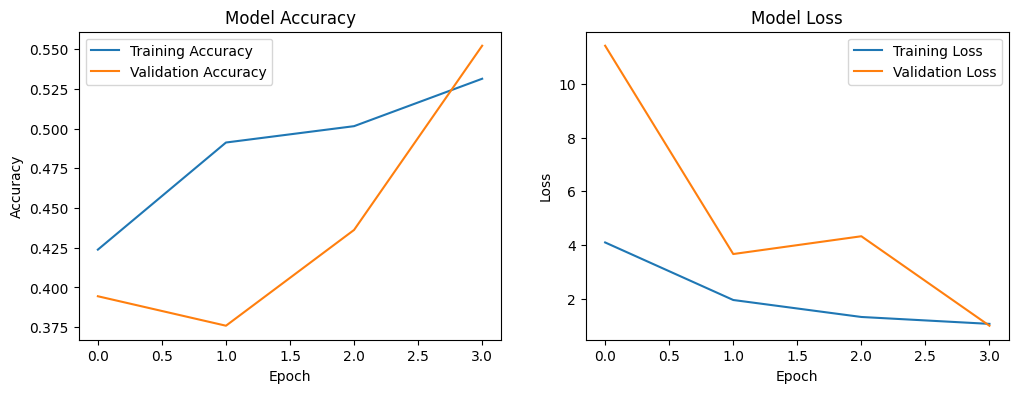

In [27]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
